### Data Preparation & Loading

In [49]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

In [50]:
# Set the random seed for reproducibility
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [51]:
# Load the stocks data
df_stocks = pd.read_csv(
    Path("../Project_2_work/api_data.csv"),
    index_col="date",
    infer_datetime_format=True,
    parse_dates=True,
)
df_stocks.head()

,open,high,low,close,volume,trade_count,vwap,symbol
date,,,,,,,,
2019-04-22,89.69,90.470,89.58,89.60,970834,9479,90.000447,BUD
2019-04-23,88.56,89.790,88.50,89.25,755451,7907,89.242818,BUD
2019-04-24,89.02,89.130,87.82,88.21,1038366,11509,88.324096,BUD
2019-04-25,86.89,87.020,86.00,86.64,1341678,13124,86.467163,BUD
2019-04-26,87.38,87.625,86.83,87.58,920430,9005,87.292918,BUD


In [52]:
# Isolating the closing data using a pivot table
all_close_prices = df_stocks.pivot(values=["close"], columns= "symbol")
all_close_prices.head()

close                                                        \
symbol        BUD    CGC   CRON     DEO    JAZZ     SAM     SPY     STZ   
date                                                                      
2019-04-22  89.60  48.25  16.86  162.58  125.97  271.34  290.27  205.46   
2019-04-23  89.25  47.41  16.28  163.80  129.78  277.73  292.88  207.48   
2019-04-24  88.21  48.37  16.59  164.13  129.42  276.43  292.23  210.14   
2019-04-25  86.64  48.20  16.52  164.17  128.53  300.00  292.05  212.16   
2019-04-26  87.58  49.91  17.16  166.48  130.99  304.56  293.41  212.16   

                                 
symbol        TAP   TLRY    VFF  
date                             
2019-04-22  61.16  51.82  11.56  
2019-04-23  61.28  50.26  11.08  
2019-04-24  62.51  51.30  12.29  
2019-04-25  62.80  51.27  11.62  
2019-04-26  63.83  53.15  11.57

### Creating input feature vectors "X" and the target vector "y"

In [53]:
#The function will have the following parameters: df_stocks, window, feature_col_number, and target_col_number. 

def window_data(df_stocks, window, feature_col_number, target_col_number):

    X = []
    y = []
    for i in range(len(df_stocks) - window):
        features = df_stocks.iloc[i : (i + window), feature_col_number]
        target = df_stocks.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)

In [54]:
window_size = 10

feature_column = [1,2,4,6,9,10]
target_column = 6
X, y = window_data(all_close_prices["close"], window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[[ 48.25  16.86 125.97 290.27  51.82  11.56]
  [ 47.41  16.28 129.78 292.88  50.26  11.08]
  [ 48.37  16.59 129.42 292.23  51.3   12.29]
  [ 48.2   16.52 128.53 292.05  51.27  11.62]
  [ 49.91  17.16 130.99 293.41  53.15  11.57]
  [ 52.03  17.01 131.05 293.87  52.73  12.01]
  [ 50.52  17.16 129.77 294.02  51.33  12.5 ]
  [ 50.68  17.06 129.62 291.81  51.95  11.9 ]
  [ 48.46  16.68 129.57 291.18  50.23  11.53]
  [ 49.08  16.57 132.32 294.03  50.22  11.79]]

 [[ 47.41  16.28 129.78 292.88  50.26  11.08]
  [ 48.37  16.59 129.42 292.23  51.3   12.29]
  [ 48.2   16.52 128.53 292.05  51.27  11.62]
  [ 49.91  17.16 130.99 293.41  53.15  11.57]
  [ 52.03  17.01 131.05 293.87  52.73  12.01]
  [ 50.52  17.16 129.77 294.02  51.33  12.5 ]
  [ 50.68  17.06 129.62 291.81  51.95  11.9 ]
  [ 48.46  16.68 129.57 291.18  50.23  11.53]
  [ 49.08  16.57 132.32 294.03  50.22  11.79]
  [ 49.2   16.34 132.81 292.82  49.79  11.9 ]]

 [[ 48.37  16.59 129.42 292.23  51.3   12.29]
  [ 48.2   16

### Splitting Data Between Training & Testing Sets 

In [55]:
# Using .90 of the data for training 
split = int(0.9 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling the Data with MinMaxScaler

In [56]:
# Scaling the data before training the LSTM model using MinMaxScaler from sklearn to scale all values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Fit scaler to reshaped X_Train
num_instances, num_time_steps, num_features = X_train.shape
X_train_reshaped = np.reshape(X_train, newshape=(-1, num_features))
scaler.fit(X_train_reshaped)
#Scale and reshape X_train to original shape
X_train_scaled = scaler.transform(X_train_reshaped)
X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))
#Scale and reshape X_test to original shape
num_instances, num_time_steps, num_features = X_test.shape
X_test_reshaped = np.reshape(X_test, newshape=(-1, num_features))
X_test_scaled = scaler.transform(X_test_reshaped)
X_test_scaled = np.reshape(X_test_scaled, newshape=(num_instances, num_time_steps, num_features))
#Fit scaler to y_train
scaler.fit(y_train)
#Scale y_train
y_train = scaler.transform(y_train)
#Scale y_test
y_test = scaler.transform(y_test)

### Build & Train the LSTM RNN/Defining the LSTM RNN Model Structure

In [57]:
# Build and Train LSTM RNN in Keeras and fit it using the training data defined above using Keras.
 # Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [58]:
# Define the LSTM RNN model by adding layers
# AND using the dropout layer to prevent overfitting. 
model = Sequential()

number_units = 100
dropout_fraction = 0.02 #Each epoch will randomly drop 20% of units to prevent overfitting.

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 6))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling, Summarizing, and Training the Model

In [59]:
# Compiling model using adam optimizer and mean_square_error
model.compile(optimizer="adam", loss="mean_squared_error")

In [60]:
# Summarizing the model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 100)           42800     
                                                                 
 dropout_9 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_10 (LSTM)              (None, 10, 100)           80400     
                                                                 
 dropout_10 (Dropout)        (None, 10, 100)           0         
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_11 (Dropout)        (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                

In [61]:
# Since the model is now defined, it will be fit using 50 epochs. 
# Batch size will be set at 128. 
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=128, verbose=1, validation_split=.1)

Epoch 1/50
5/5 [==============================] - 9s 465ms/step - loss: 0.0795 - val_loss: 0.0742
Epoch 2/50
5/5 [==============================] - 0s 67ms/step - loss: 0.1181 - val_loss: 0.2657
Epoch 3/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0504 - val_loss: 0.1865
Epoch 4/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0426 - val_loss: 0.1191
Epoch 5/50
5/5 [==============================] - 0s 61ms/step - loss: 0.0546 - val_loss: 0.1513
Epoch 6/50
5/5 [==============================] - 0s 63ms/step - loss: 0.0450 - val_loss: 0.1504
Epoch 7/50
5/5 [==============================] - 0s 66ms/step - loss: 0.0363 - val_loss: 0.1051
Epoch 8/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0446 - val_loss: 0.1204
Epoch 9/50
5/5 [==============================] - 0s 66ms/step - loss: 0.0435 - val_loss: 0.1510
Epoch 10/50
5/5 [==============================] - 0s 62ms/step - loss: 0.0325 - val_loss: 0.1185
Epoch 11/50
5/5 [===========

### Model Performance

In [62]:
# Evaluating the model
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 11ms/step - loss: 0.0108


0.01078278198838234

In [63]:
# Make predictions
predicted = model.predict(X_test, batch_size=128)
predicted

1/1 [==============================] - 2s 2s/step


array([[0.8912059 ],
       [0.8935385 ],
       [0.8954895 ],
       [0.8973815 ],
       [0.89963335],
       [0.90217215],
       [0.9071294 ],
       [0.91408235],
       [0.9220224 ],
       [0.93074566],
       [0.93881637],
       [0.94525373],
       [0.95120746],
       [0.9557933 ],
       [0.9571254 ],
       [0.95460093],
       [0.9471412 ],
       [0.93917197],
       [0.9318677 ],
       [0.92573243],
       [0.92135435],
       [0.9191923 ],
       [0.9188983 ],
       [0.919316  ],
       [0.9211044 ],
       [0.92420447],
       [0.92863303],
       [0.93341506],
       [0.9371998 ],
       [0.9390262 ],
       [0.93923223],
       [0.9399515 ],
       [0.94176704],
       [0.9429007 ],
       [0.9428414 ],
       [0.9414862 ],
       [0.9378982 ],
       [0.9336097 ],
       [0.93085325],
       [0.92852   ],
       [0.9250522 ],
       [0.91795903],
       [0.9099758 ],
       [0.900634  ],
       [0.887932  ],
       [0.8753255 ],
       [0.867145  ],
       [0.845

### Plotting Predicted Vs. Real Prices

In [64]:
# Create a DataFrame of Real and Predicted values
df_values = pd.DataFrame({
    "Real": y_test.ravel(),
    "Predicted": predicted.ravel()
    }, index = df_stocks.index[-len(y_test): ])
df_values.head()

,Real,Predicted
date,,
2022-01-03,1.000904,0.891206
2022-01-04,1.000275,0.893538
2022-01-05,0.964248,0.895490
2022-01-06,0.962519,0.897381
2022-01-07,0.955251,0.899633


<AxesSubplot:xlabel='date'>

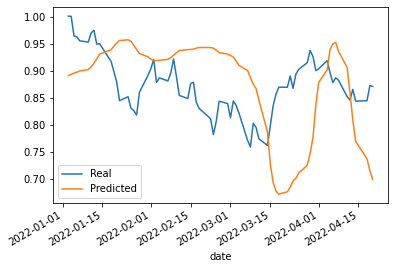

In [65]:
# PLotting real prices vs. predicted
df_values.plot(kind ="line")